# Model for elbow detection

The aim is to develop probabilistic elbow detection algorithm, i.e. to detect a change in the gradient of a line which is specified by scattered (x, y) pairs.

In [1]:
import numpy as np
import numpy.random as npr

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import typing as tp

import tensorflow as tf
import tensorflow_probability as tfp

import scipy as sp
import scipy.stats as sp_sts

2022-03-26 14:04:20.291473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 14:04:20.291493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Model for the elbow

Assume that data follows linear trend with gradient $m$, intercept $c$ and normally distributed errors with amplitude $\sigma=\sqrt{\sigma^2}$:

$$
\begin{align}
y&=m\cdot x + c + \sigma \cdot n \\
n&\sim N\left(0,\,1\right) \\
m&=m_l + S\left(\frac{x-x^*}{\alpha}\right)\cdot\left(m_r-m_l\right) \\
\sigma^2&=\sigma^2_l + S\left(\frac{x-x^*}{\alpha}\right)\cdot\left(\sigma^2_r-\sigma^2_l\right) \\
c_{l,r}&=y^* - m_{l,r}\cdot x^* \\
S\left(x\right)&=\frac{\exp\left(x\right)}{1+\exp\left(x\right)}
\end{align}
$$


The key parameters are:
    
* $x^*,\,y^*$ - the position of the elbow
* $m_{l,r}$ - gradients of the left and right portions of the line
* $c_{l,r}$ - intercepts of the left and right portions of the line
* $\sigma^2_{l,r}$ - variances of the normal fit for the left and right portions
* $\alpha$ - scale for the change in sigmoid

## Likelihood

The likelihood of the pair of points $\left(x,\,y\right)$ is therefore:

$$
\left(x,\,y\right) \sim N\left(y-\left(m\cdot x + c\right), \sigma^2\right)
$$

Where $m,\,c,\,\sigma^2$ depend on $x$

## Generate sample data

Useful both for fitting as well as exploring good priors

In [2]:
chosen_x_min = 0.
chosen_x_max = 1.
#
chosen_m_l = -1.
6
chosen_m_r = -0.01
#
chosen_alpha = 0.05
#
chosen_sig2_l = 0.0003
chosen_sig2_r = 0.0006
#
chosen_elbw_x = 0.3
chosen_elbw_y = 0.0
#
chosen_y_min = chosen_elbw_y + chosen_m_l * (chosen_x_min - chosen_elbw_x)
chosen_y_max = chosen_elbw_y + chosen_m_r * (chosen_x_max - chosen_elbw_x)
#
logit = lambda s: np.log(s/(1-s))
chosen_eta_x = logit( (chosen_elbw_x - chosen_x_min)/(chosen_x_max - chosen_x_min) ) 
chosen_eta_y = logit( (chosen_elbw_y - chosen_y_min)/(chosen_y_max - chosen_y_min) ) 

data_prob_model = tfp.distributions.JointDistributionNamed({
    'x': tfp.distributions.Uniform(chosen_x_min, chosen_x_max),
    's': lambda x: tfp.distributions.Deterministic(
            tf.math.sigmoid((x-chosen_elbw_x)/chosen_alpha)
        ),
    'm': lambda s: tfp.distributions.Deterministic(
            chosen_m_l + s * (chosen_m_r - chosen_m_l)
        ),
    'sig2': lambda s: tfp.distributions.Deterministic(
            chosen_sig2_l + s * (chosen_sig2_r - chosen_sig2_l)
        ),
    'c': lambda m: tfp.distributions.Deterministic(
            chosen_elbw_y - m*chosen_elbw_x
        ),
    'y': lambda x, m, c, sig2: tfp.distributions.Normal(x*m+c, tf.sqrt(sig2)) 
})


################
fitting_sample = data_prob_model.sample(500)

fitting_xy = tf.stack([fitting_sample['x'], fitting_sample['y']], axis=1)

2022-03-26 14:04:21.575663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-26 14:04:21.575681: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-26 14:04:21.575693: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cryo-Latitude-7300): /proc/driver/nvidia/version does not exist
2022-03-26 14:04:21.575872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


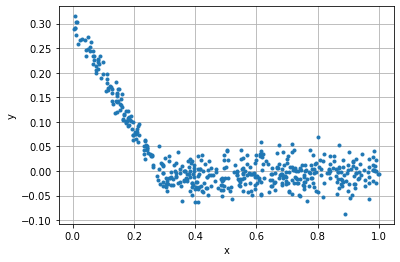

In [3]:

fig, ax = pp.subplots()
#
ax.plot(fitting_xy.numpy()[:,0], fitting_xy.numpy()[:,1], '.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
#ax.set_ylim([-15, 5])

## Prior

Let $x^*\in\left(x_0,\,x_1\right)$ and $y^*\in\left(y_0,\,y_1\right)$ we then assume:

$$
\begin{align}
r_x&=\frac{x^*-x_0}{x_1-x_0} \\
r_y&=\frac{y^*-y_0}{y_1-y_0}
\end{align}
$$

and to stick it on the real line:

$$
\begin{align}
r_{x,y}&=S\left(\eta_{x,y}\right) \\
\eta_{x,y}&\sim N\left(0,\,1\right)
\end{align}
$$

In other words, assume that:

$$
\begin{align}
x^*&=x_0 + S\left(\eta_x\right)\cdot\left(x_1-x_0\right) \\
y^*&=y_0 + S\left(\eta_y\right)\cdot\left(y_1-y_0\right) \\
\end{align}
$$

For variance-type variables apply log-transform:

$$
\begin{align}
\sigma^2_{l,r}&=\exp\left(\lambda_{l,r}\right) \\
\alpha&=\exp\left(\lambda_a\right)
\end{align}
$$

Suitable distributions for the prior are then:

$$
\begin{align}
\eta_{x,y} &\sim N\left(\dots\right) \\
m_{l,r} &\sim N\left(\dots\right) \\
\lambda_{l,r,a} & \sim Exp-inv-\chi^2\left(\dots\right)\end{align}
$$

Which allows all core variables to vary along the full real line

In [4]:
def estimate_prior_params(
    x_arr: np.ndarray,
    y_arr: np.ndarray,
    bootstrap_count: int=10
)->tp.Dict[str, float]:
    """
    Given a set of x and y points that contain two linear segments and an elbow 
    use simple polynomial fitting to estimate a range of reasonable gradients 
    for the two linear segments, and a range of reasonable positions for the elbow.
    
    Bootstrapping, i.e. sampling with replacement is used to get the estimates
    
    Arguments:
    ----------
        x_arr: array of horizontal positions of the points used to generate 
        	estimates for the priors
        y_arr: vertical positions ...
        bootstrap_count: number of iterations for bootstrapping
        
    Returns:
    --------
        Dictionary (str->float) with m_mean, m_var, the mean and variance 
        for the gradient as well as the mean squared error from the linear fit.
    """
    bstr_m_arr = []
    bstr_c_arr = []
    bstr_ys2_arr = []
    
    for i_run in range(bootstrap_count):
        i_arg_choice = npr.choice(np.arange(len(x_arr)), size=len(x_arr), replace=True)
        cur_x_arr = x_arr[i_arg_choice]
        cur_y_arr = y_arr[i_arg_choice]
        
        cur_m, cur_c = np.polyfit(cur_x_arr, cur_y_arr, deg=1)
        cur_ys2 = np.var(cur_y_arr - (cur_m*cur_x_arr + cur_c))
        
        bstr_m_arr.append(cur_m)
        bstr_c_arr.append(cur_c)
        bstr_ys2_arr.append(cur_ys2)
    
    bstr_param = {
        'm_mean': np.mean(bstr_m_arr),
        'm_var': np.var(bstr_m_arr),
        'ys2_mean': np.mean(bstr_ys2_arr)
    }
    
    return bstr_param

####


def get_prior_distribution(
    m_mean: float=0.0,
    m_var: float=1.0,
    ys2_mean: float=1.0,
    lam_lr_nu: float=5.0,
    alpha_mean: float=1.0,
    lam_a_nu: float=5.0,
    eta_x_mean: float=0.0,
    eta_y_mean: float=0.0,
    eta_x_var: float=1.0,
    eta_y_var: float=1.0
)->tfp.distributions.JointDistributionNamed:
    """
    Get a prior distribution for the key parameters being modelled. eta-s 
    and m-s are simple normal distrobutions. Lambdas are usedto model variances 
    i.e. exp(lambda)=Variance. A good prior distribution for exp(lambda) 
    is therefore scaled inverse chi-squared
    
    Tensorflow only supports Inverse-Gamma, which is equivalent.
    
    so exp(lambda) ~ Inv-Gamma
    so lambda ~ Exp-Inv-Gamma(nu/2, nu * tau^2/2)
    
    Next need the parameters. nu would be the number of degrees of freedom 
    for chi-2. Good idea to keep this low, but exact value is not important. 
    Therefore choosing to keep it at nu=5, which gives a well-defined variance 
    for lambda. Next, from 
    [wiki](https://en.wikipedia.org/wiki/Scaled_inverse_chi-squared_distribution) 
    it follows that
    
    E[exp(lam)] = nu^2 tau / (nu-2)
    Var[exp(lam)] = 2 * E[exp(lam)]/nu-4
    
    Will ignore Var, since nu is fixed already. Will only set 
    tau=(nu-2) * E[exp(lam)]/nu^2
    
    Arguments:
    ----------
        m_mean: mean for gradients (normal distribution)
        m_var: variance for gradients
        ys2_mean: mean residual squared of the linear fit to the data. 
        	This is essentially a rough mean of the 
            variance. Goes into fitting Exp-Inv-Gamma distirbution
        lam_lr_nu: nu for Exp-Inv-Gamma distribution for the left and right 
        	variance prior. Should not need to change this
        alpha_mean: rough estimate of the mean for Exp-Inv-Gamma prior for 
        	alpha - the scale of smooth change at the elbow
        lam_a_nu: nu for the Exp-Inv-Gamma that models alpha=exp(lambda)
        eta_x_mean: mean for the normal distribution of the elbow position
        eta_x_var: ditto variance
        eta_y_mean: ditto y
        eta_y_mean: ditto variance for y
        
    Returns:
    --------
        Joint named probabiity distribution for eta_x, eta_y, m_l, m_r, 
        	lam_l, lam_r, lam_a
    """
    
    lam_lr_tau2 = tf.constant(ys2_mean*(lam_lr_nu-2)/lam_lr_nu, dtype=tf.float32)
    lam_lr_a = tf.constant(lam_lr_nu/2, dtype=tf.float32)
    lam_lr_b = tf.constant(lam_lr_nu * lam_lr_tau2/2, dtype=tf.float32)
    
    lam_a_tau2 = tf.constant(alpha_mean*(lam_a_nu-2)/lam_a_nu, dtype=tf.float32)
    lam_a_a = tf.constant(lam_a_nu/2, dtype=tf.float32)
    lam_a_b = tf.constant(lam_a_nu * lam_a_tau2/2, dtype=tf.float32)
    
    # NB! bear in mind that in TFP normal distribution takes in standard deviation, not variance
    prior_distr = tfp.distributions.JointDistributionNamed({
        'eta_x': tfp.distributions.Normal(tf.constant(eta_x_mean, dtype=tf.float32), tf.sqrt(tf.constant(eta_x_var, dtype=tf.float32))),
        'eta_y': tfp.distributions.Normal(tf.constant(eta_y_mean, dtype=tf.float32), tf.sqrt(tf.constant(eta_y_var, dtype=tf.float32))),
        'm_l': tfp.distributions.Normal(tf.constant(m_mean, dtype=tf.float32), tf.sqrt(tf.constant(m_var, dtype=tf.float32))),
        'm_r': tfp.distributions.Normal(tf.constant(m_mean, dtype=tf.float32), tf.sqrt(tf.constant(m_var, dtype=tf.float32))),
        'lam_l': tfp.distributions.ExpInverseGamma(lam_lr_a, lam_lr_b),
        'lam_r': tfp.distributions.ExpInverseGamma(lam_lr_a, lam_lr_b),
        'lam_a': tfp.distributions.ExpInverseGamma(lam_a_a, lam_a_b)
    })
    
    return prior_distr
    
###

prior_est_dict = estimate_prior_params(fitting_xy[:50,0].numpy(), fitting_xy[:50,1].numpy())
print(prior_est_dict)
print(get_prior_distribution(
    m_mean=prior_est_dict['m_mean'],
    m_var=prior_est_dict['m_var'],
    ys2_mean=prior_est_dict['ys2_mean']
).sample(5))

{'m_mean': -0.1655877279934952, 'm_var': 0.0022381889030217103, 'ys2_mean': 0.003148406}
{'m_r': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.18905191, -0.17334662, -0.2507878 , -0.17077348, -0.2625584 ],
      dtype=float32)>, 'm_l': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.1572504 , -0.2556644 , -0.15866011, -0.159875  , -0.09018636],
      dtype=float32)>, 'lam_r': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-6.700796 , -5.959574 , -6.511948 , -5.590578 , -5.5393147],
      dtype=float32)>, 'lam_l': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-5.6209545, -5.8908997, -4.4619493, -6.0297103, -5.8676834],
      dtype=float32)>, 'lam_a': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.03853863,  0.301782  , -1.1809101 , -0.7884095 ,  0.48218626],
      dtype=float32)>, 'eta_y': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.2156955 ,  0.03090582, -0.63796073,  0.2823157 ,  0.26177678],
      dtype=float32)>, 'eta_x': <tf.Tenso

2022-03-26 14:04:22.220958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Likelihood

Having constructed prior we can now move to likelihood and posterior. Starting with log-likelihood which is obtained by re-arranging for $n$, the noise term:

$$
n=\frac{y-m\cdot x - c}{\sigma}
$$

By definition $n$ is the normal variable, so the likelihood of $\left(y,\,x\right)$ given $m,\,c,\,\sigma$ is:

$$
\begin{align}
L\left((x,\, y)\right)&=\frac{1}{\sqrt{2\pi\sigma^2}}\cdot\exp\left(-\frac{\left(y-m\cdot x -c\right)^2}{2\sigma^2}\right) \\
l\left((x,\, y)\right)&=\log L\left((x,\, y)\right)=-\frac{\left(y-m\cdot x -c\right)^2}{2\sigma^2}-\frac{\log\left(2\pi\cdot\sigma^2\right)}{2}
\end{align}
$$

In [5]:
def log_lkhd(
    eta_x: tf.Tensor,
    eta_y: tf.Tensor,
    m_l: tf.Tensor,
    m_r: tf.Tensor,
    lam_l: tf.Tensor,
    lam_r: tf.Tensor,
    lam_a: tf.Tensor,
    xy_data: tf.Tensor=fitting_xy # shape (N, 2) where N is the number of points
)->tf.Tensor:
    """
    Accept eta_x, eta_y, m_l, m_r, lam_l, lam_r, lam_a and actual data (xy_data) as 
    tensors and return tensor-valued log-likelihood. The data (xy_data) is asssumed
    to be distributed along the zeroth dimension, whilst parameters are distributed
    along higher dimnesions. All parameters (eta_..., m_..., lam_...) should have the
    same shape. The returned log_likelihood will also be of that shape.
    
    The function is built to be differentiable, i.e. all internal math is within tensors
    
    Arguments:
    ----------
        eta_x: param linked to the horizontal position of the elbow
        eta_y: param linked to the vertical position of the elbow
        m_l: gradient to the left
        m_r: gradient to the right
        lam_l: param linked to variance to the left
        lam_r: param linked to variance to the right
        lam_a: param linked to the scale of the sigmoid change
        xy_data: N,2 tensor with (x,y) pairs of the data we are trying to fit
        
    Returns:
    --------
        tensor of log-likelihoods for different sets of parameters. this is the log-likelihood
        of all data-points together. Same shape as eta_x
    """
    
    # begin by reshaping the input parameters so that first dimension is a singleton for the data
    param_count = tf.reshape(eta_x, [-1]).shape[0]
    
    #
    expanded_eta_x = tf.reshape(eta_x, [1, param_count])
    expanded_eta_y = tf.reshape(eta_y, [1, param_count])
    expanded_m_l = tf.reshape(m_l, [1, param_count])
    expanded_m_r = tf.reshape(m_r, [1, param_count])
    expanded_lam_l = tf.reshape(lam_l, [1, param_count])
    expanded_lam_r = tf.reshape(lam_r, [1, param_count])
    expanded_lam_a = tf.reshape(lam_a, [1, param_count])
    
    # reshape data to have it running along zeroth dimension with repititions 
    # along the first dimension for different params
    expanded_x = tf.repeat(tf.reshape(xy_data[:,0], shape=[-1,1]), repeats=param_count, axis=1)
    expanded_y = tf.repeat(tf.reshape(xy_data[:,1], shape=[-1,1]), repeats=param_count, axis=1)
    
    # prepare final params
    expanded_sig2_l = tf.exp(expanded_lam_l)
    expanded_sig2_r = tf.exp(expanded_lam_r)
    expanded_alpha = tf.exp(expanded_lam_a)
    #
    x_min = tf.reduce_min(xy_data[:,0])
    x_max = tf.reduce_max(xy_data[:,0])
    y_min = tf.reduce_min(xy_data[:,1])
    y_max = tf.reduce_max(xy_data[:,1])
    #
    expanded_elbw_x = x_min + (x_max - x_min) * tf.sigmoid(expanded_eta_x)
    expanded_elbw_y = y_min + (y_max - y_min) * tf.sigmoid(expanded_eta_y)
    
    # compute log-likelihood
    # for each point
    s_arr = tf.sigmoid(
        (
            expanded_x-tf.repeat(expanded_elbw_x, repeats=expanded_x.shape[0], axis=0)
        )/tf.repeat(expanded_alpha, repeats=xy_data.shape[0], axis=0)
    )
    #
    m_arr = tf.repeat(expanded_m_l, repeats=s_arr.shape[0], axis=0) + (s_arr * (
        tf.repeat(expanded_m_r, repeats=s_arr.shape[0], axis=0) - tf.repeat(expanded_m_l, repeats=s_arr.shape[0], axis=0)
    ))
    #
    sig2_arr = tf.repeat(expanded_sig2_l, repeats=s_arr.shape[0], axis=0) + (s_arr * (
        tf.repeat(expanded_sig2_r, repeats=s_arr.shape[0], axis=0) - tf.repeat(expanded_sig2_l, repeats=s_arr.shape[0], axis=0)
    ))
    #
    c_arr = tf.repeat(expanded_elbw_y, repeats=s_arr.shape[0], axis=0) - (m_arr * tf.repeat(expanded_elbw_x, repeats=s_arr.shape[0], axis=0))
    #
    log_lkhd_arr = - (tf.math.log(2*np.pi*sig2_arr)/2.) - tf.pow(expanded_y - ((expanded_x * m_arr) + c_arr), 2)/(2.*sig2_arr) 
    
    # collapse for all data points
    log_lkhd = tf.reduce_sum(log_lkhd_arr, axis=0)
    
    # reshape to fit the shape of the params
    return tf.reshape(log_lkhd, shape=eta_x.shape)

#######

def log_posterior(
    eta_x: tf.Tensor,
    eta_y: tf.Tensor,
    m_l: tf.Tensor,
    m_r: tf.Tensor,
    lam_l: tf.Tensor,
    lam_r: tf.Tensor,
    lam_a: tf.Tensor,
    xy_data: tf.Tensor=fitting_xy,
    prior_distribution: tfp.distributions.JointDistributionNamed=None
)->tf.Tensor:
    """
    Accept eta_x, eta_y, m_l, m_r, lam_l, lam_r, lam_a and actual data (xy_data) as 
    tensors, and prior as a distribution. Return tensor-valued log-posterior. 
    See log_lkhd for more details on parameters
    Posterior is the product of likelihood and prior, so log-posterior is the sum
    
    The function is built to be differentiable, i.e. all internal math is within tensors
    
    Arguments:
    ----------
        eta_x: param linked to the horizontal position of the elbow
        eta_y: param linked to the vertical position of the elbow
        m_l: gradient to the left
        m_r: gradient to the right
        lam_l: param linked to variance to the left
        lam_r: param linked to variance to the right
        lam_a: param linked to the scale of the sigmoid change
        xy_data: N,2 tensor with (x,y) pairs of the data we are trying to fit
        prior_distribution: distribution that has `log_prob` method which returns
            prior probability of eta_..., m_..., lam_... params 
        
    Returns:
    --------
        tensor of log-likelihoods for different sets of parameters. this is the log-likelihood
        of all data-points together. Same shape as eta_x
    """
    
    # get probability of params under prior
    log_prior_tens = prior_distribution.log_prob(
        eta_x=eta_x,
        eta_y=eta_y,
        m_l=m_l,
        m_r=m_r,
        lam_l=lam_l,
        lam_r=lam_r,
        lam_a=lam_a
    )
    
    # get likelihood
    log_lkhd_tens = log_lkhd(
        eta_x=eta_x,
        eta_y=eta_y,
        m_l=m_l,
        m_r=m_r,
        lam_l=lam_l,
        lam_r=lam_r,
        lam_a=lam_a,
        xy_data=xy_data
    )
    
    log_post_tens =  log_prior_tens + log_lkhd_tens
    
    return log_post_tens

#####

prior_distr = get_prior_distribution()
N = 10
#log_lkhd(eta_x=tf.constant(chosen_eta_x, dtype=tf.float32), eta_y=tf.constant(chosen_eta_y, dtype=tf.float32))
log_posterior(
    eta_x=tf.constant([chosen_eta_x]*N, dtype=tf.float32),
    eta_y=tf.constant([chosen_eta_y]*N, dtype=tf.float32),
    m_l=tf.constant([chosen_m_l]*N, dtype=tf.float32),
    m_r=tf.constant([chosen_m_r]*N, dtype=tf.float32),
    lam_l=tf.math.log(tf.constant([chosen_sig2_l]*N, dtype=tf.float32)),
    lam_r=tf.math.log(tf.constant([chosen_sig2_r]*N, dtype=tf.float32)),
    lam_a=tf.math.log(tf.constant([chosen_alpha]*N, dtype=tf.float32)),
    prior_distribution=prior_distr
)   

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-55110.258, -55110.258, -55110.258, -55110.258, -55110.258,
       -55110.258, -55110.258, -55110.258, -55110.258, -55110.258],
      dtype=float32)>

## Markov Chain Monte Carlo (MCMC)

Next we sample from the posterior distribution using MCMC, and more specifically Hamiltonian Monte Carlo. The sampling is done for ~200 chains in parallel. Chains are initialized from the prior.

In [28]:
######### HMC
@tf.function(jit_compile=True)
def hmc_mcmc_sample(
    log_post_func: tp.Callable[[tf.Tensor]*7, tf.Tensor],
    init_state: tp.List[tf.Tensor],
    num_burnin_steps: int=1000,
    num_results: int=100,
    step_size: float=0.05,
    num_leapfrog_steps=3,
)->tf.Tensor:
    """
    Run MCMC using basic Hamiltonian Monte-Carlo
    
    Arguments:
    ----------
        log_post_func: function that accepts tensors for mu and 
            lam and returns log-probability for the posterior 
        init_state: initial state for MCMC, for mu and lam, eta, 
            beta, alpha, mu_x with shapes (K, 1) where K is the number of chains
        num_burnin_steps: number of burn-in steps see 
            `tensorflow_probability.mcmc.sample_chain`
        num_results: number of results per chain see 
            `tensorflow_probability.mcmc.sample_chain`
        step_size: size of the step for HMC
        num_leapfrog_steps: see HMC
        
    Returns:
    --------
        A list of tensors ([lam, eta, beta, alpha, mu_x]) with the results. 
        The shape of the tensors includes number of results and number of chains
    """
    
    # basic kernel
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_post_func,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size
    )
    
    # adaptive step
    ahmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    )
    
    # actual mmcmc
    sampled_chain = tfp.mcmc.sample_chain(
        kernel=ahmc_kernel,
        trace_fn=None,
        current_state=init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=num_results
    )
    
    return sampled_chain


##########################
  
# set-up initial state
# list of tensors, one tensor per parameter
# the shape of the tensors should be (*, 1) where the number of elements along the zeroth
# dimension determines the number of chains
chain_count = 200
#

prior_est_dict = estimate_prior_params(fitting_xy[:20,0].numpy(), fitting_xy[:20,1].numpy())
prior_distribution = get_prior_distribution(
    m_mean=prior_est_dict['m_mean'],
    m_var=prior_est_dict['m_var'],
    eta_x_var=0.1,
    eta_y_var=0.1,
    ys2_mean=prior_est_dict['ys2_mean']
)

# rig the posterior log-probability so that it only needs
# key inputs
rigged_log_post_func = lambda eta_x, eta_y, m_l, m_r, lam_l, lam_r, lam_a: \
    log_posterior(
        eta_x=eta_x,
        eta_y=eta_y,
        m_l=m_l,
        m_r=m_r,
        lam_l=lam_l,
        lam_r=lam_r,
        lam_a=lam_a,
        xy_data=fitting_xy,
        prior_distribution=prior_distribution
    )


# prepare chain starting positions
# will initialize chains from prior
initial_tens_dict = prior_distribution.sample(chain_count)

param_order_list = ['eta_x', 'eta_y', 'm_l', 'm_r', 'lam_l', 'lam_r', 'lam_a']
mcmc_init_state = [
    tf.reshape(initial_tens_dict[key], shape=[chain_count, 1])
    for key in param_order_list
]

# number of steps to jump before we read out the results from MCMC
num_burnin_steps = 50000 

# number of samples from each chain
samples_per_chain = 1000

####
print('Running chain')

# run the chain
sampler_choice = 'hmc'

if sampler_choice == 'hmc':
    chain_list = hmc_mcmc_sample(
        log_post_func=rigged_log_post_func,
        init_state=mcmc_init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=samples_per_chain,
        step_size=0.1,
        num_leapfrog_steps=3
    )
else:
    raise Exception('Not implemented')

print('Done')

Running chain
Done


It is convenient to unpack the results and prepare prior for comparison

In [7]:
# unpack to dictionary
#
results_dict = {
    key: chain_list[i_key]
    for i_key, key in enumerate(param_order_list)
}

results_dict['elbw_x'] = tf.sigmoid(results_dict['eta_x'])*(
    tf.reduce_max(fitting_xy[:,0]) - tf.reduce_min(fitting_xy[:,0])
) + tf.reduce_min(fitting_xy[:,0])
#
results_dict['elbw_y'] = tf.sigmoid(results_dict['eta_y'])*(
    tf.reduce_max(fitting_xy[:,1]) - tf.reduce_min(fitting_xy[:,1])
) + tf.reduce_min(fitting_xy[:,1])
#
results_dict['sig2_l'] = tf.exp(results_dict['lam_l'])
results_dict['sig2_r'] = tf.exp(results_dict['lam_r'])
results_dict['alpha'] = tf.exp(results_dict['lam_a'])

### add prior

prior_dict = prior_distribution.sample(10000)
#
prior_dict['elbw_x'] = tf.sigmoid(prior_dict['eta_x'])*(
    tf.reduce_max(fitting_xy[:,0]) - tf.reduce_min(fitting_xy[:,0])
) + tf.reduce_min(fitting_xy[:,0])
#
prior_dict['elbw_y'] = tf.sigmoid(prior_dict['eta_y'])*(
    tf.reduce_max(fitting_xy[:,1]) - tf.reduce_min(fitting_xy[:,1])
) + tf.reduce_min(fitting_xy[:,1])
#
prior_dict['sig2_l'] = tf.exp(prior_dict['lam_l'])
prior_dict['sig2_r'] = tf.exp(prior_dict['lam_r'])
prior_dict['alpha'] = tf.exp(prior_dict['lam_a'])

#### add chosen
chosen_dict = {}
chosen_dict['m_l'] = chosen_m_l
chosen_dict['m_r'] = chosen_m_r
#
chosen_dict['alpha'] = chosen_alpha
#
chosen_dict['sig2_l'] = chosen_sig2_l
chosen_dict['sig2_r'] = chosen_sig2_r
#
chosen_dict['elbw_x'] = chosen_elbw_x
chosen_dict['elbw_y'] = chosen_elbw_y

## Viewing results

Now that we have the posterior fit for the parameters one may want to compare it to prior, as well as to the actual input used to generate the data. It is also a good idea to compare individual histograms from different chains. What we are looking for there is convergence to a single distribution

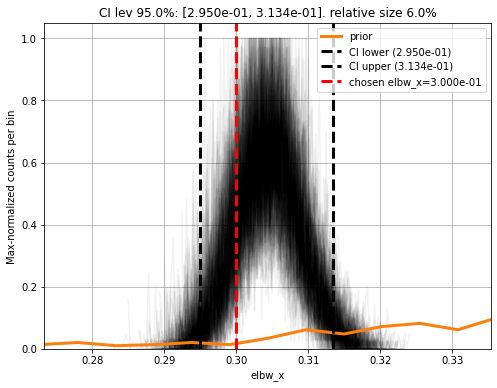

In [29]:
key_param = 'elbw_x'

# extract the points of the relevant param, for prior and posterior
# as a numpy array
param_arr = np.squeeze(results_dict[key_param].numpy())
prior_arr = np.squeeze(prior_dict[key_param].numpy())

# configure histogram display
ci_lev = 0.95
ci_lim = [(1-ci_lev)/2, 1-(1-ci_lev)/2]
bin_count = int(samples_per_chain/10)

#### plot

fig, ax = pp.subplots(figsize=(8, 6))

# in each step of the loop extract the histogram
# for one chais from the posterior and plot the outline of the 
# historgram as a semi-transparent line
for i_chain in range(chain_count):
    cur_chain = param_arr[:, i_chain]
    
    hist_counts, hist_bins = np.histogram(cur_chain, bins=bin_count)
    hist_bin_mid_points = (hist_bins[1:] + hist_bins[:-1])/2
    
    ax.plot(hist_bin_mid_points, hist_counts/np.max(hist_counts), color='k', alpha=0.05)    
    
# add some reference info - what prior looks like
prior_hist_counts, prior_hist_bins = np.histogram(prior_arr, bins=bin_count)
prior_hist_bin_mid_points = (prior_hist_bins[1:] + prior_hist_bins[:-1])/2   
ax.plot(
    prior_hist_bin_mid_points, 
    prior_hist_counts/np.max(prior_hist_counts), 
    color='tab:orange', 
    alpha=1.0, 
    label='prior',
    linewidth=3
)

ax.axvline(np.quantile(param_arr, ci_lim[0]), color='k', linewidth=3, linestyle='--', label=f'CI lower ({np.quantile(param_arr, ci_lim[0]):.3e})')
ax.axvline(np.quantile(param_arr, ci_lim[1]), color='k', linewidth=3, linestyle='--', label=f'CI upper ({np.quantile(param_arr, ci_lim[1]):.3e})')
ax.set_xlabel(key_param)
ax.grid()
ci_lim_real = np.quantile(param_arr, ci_lim)
ax.set_title(f'CI lev {ci_lev*100:.1f}%: [{ci_lim_real[0]:.3e}, {ci_lim_real[1]:.3e}]. '+\
            f'relative size {np.abs((ci_lim_real[1]-ci_lim_real[0])/((ci_lim_real[0]+ci_lim_real[1])/2)*100):.1f}%')

ax.set_ylabel('Max-normalized counts per bin')
ax.set_ylim([0, 1.05])
ax.axvline(chosen_dict[key_param], color='r', linewidth=3, linestyle='--', label=f'chosen {key_param}={chosen_dict[key_param]:.3e}')

param_median = np.quantile(param_arr, 0.5)
param_iqr = np.quantile(param_arr, 0.75) - np.quantile(param_arr, 0.25) 
x_lims = [param_median - 5*param_iqr, param_median + 5*param_iqr]

ax.set_xlim(x_lims)
ax.legend()

Also create a quantile plot to compare with the data. That is plot $x$ vs such value of $Y$ that $q*100$% of probable $y$ will be below $Y_q$, where $q$ is the quantile of interest. Let $n_q$ be the corresponding quantile normal random variable $n$. Distribution of $y$ depends on $n$ as well as on the posterior distribution of the parameters. Marginalizing the posterior beliefs one gets the posterior predictive distribution for $y$:

$$
\tilde{f}\left(y|x\right)=\int_{\Omega} d\omega f\left(y|x \,\big|\, \omega\right) h\left(\omega\right) 
$$

Where integral over $\omega$ is the integral over all parameters, i.e. $\omega=\{m_l\,\dots\}$, $f=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\left(\frac{y-m\cdot x-c}{2\sigma^2}\right)^2\right)$ is the probability density for $y$, given $x$ and all other parameters. Finally, $h$ is the posterior probability density for the parameters. In this case we have sampled from $h$ so the posterior predictive is simply the average over all sampled parameters $\Omega_s$:

$$
\tilde{f}\left(y|x\right)=\mbox{Avg}_{\omega \in \Omega_s} f\left(y|x \,\big|\, \omega\right)
$$

Probability of $y$ being at or below $Y$ is therefore:

$$
P\left[y\le Y_q\right]=\mbox{Avg}_{\omega \in \Omega_s} P\left[n=\frac{y-m_\omega\cdot x-c_\omega}{\sigma_\omega}\,\le\, \frac{Y_q-m_\omega\cdot x-c_\omega}{\sigma_\omega}\right]=q
$$

Which can be written as:

$$
Y_q=\mbox{Avg}_{\omega \in \Omega_s}\left(m_\omega\cdot x +c_\omega + \sigma_\omega n_q\right)
$$

Text(0.5, 1.0, 'Experimental data and quantiles of the predictive posterior: [0.05, 0.5, 0.95]')

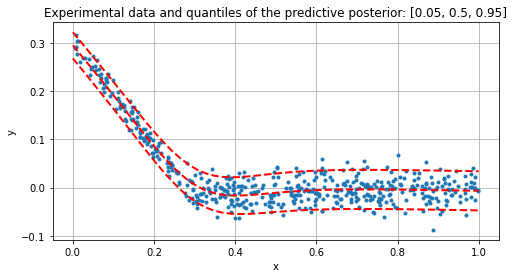

In [31]:
# which quantiles we want to plot
quant_arr = [0.05, 0.5, 0.95]

# array for evaluating x
x_arr = np.linspace(0, 1.0, 50)

# prepare all sampled posterior with samples running along axis=1
elbw_x_tens = np.repeat(np.squeeze(results_dict['elbw_x'].numpy()).reshape([1, -1]), repeats=len(x_arr), axis=0)
elbw_y_tens = np.repeat(np.squeeze(results_dict['elbw_y'].numpy()).reshape([1, -1]), repeats=len(x_arr), axis=0)
alpha_tens = np.repeat(np.squeeze(results_dict['alpha'].numpy()).reshape([1, -1]), repeats=len(x_arr), axis=0)
m_l_tens = np.repeat(np.squeeze(results_dict['m_l'].numpy()).reshape([1, -1]), repeats=len(x_arr), axis=0)
m_r_tens = np.repeat(np.squeeze(results_dict['m_r'].numpy()).reshape([1, -1]), repeats=len(x_arr), axis=0)
sig2_l_tens = np.repeat(np.squeeze(results_dict['sig2_l'].numpy()).reshape([1, -1]), repeats=len(x_arr), axis=0)
sig2_r_tens = np.repeat(np.squeeze(results_dict['sig2_r'].numpy()).reshape([1, -1]), repeats=len(x_arr), axis=0)
#
x_tens = np.repeat(x_arr.reshape([-1, 1]), repeats=elbw_x_tens.shape[1], axis=1)
exp_tens = np.exp((x_tens-elbw_x_tens)/alpha_tens)
s_tens = exp_tens/(1+exp_tens)
#
m_tens = m_l_tens + s_tens*(m_r_tens-m_l_tens)
c_tens = elbw_y_tens - (m_tens * elbw_x_tens)
sig2_tens = sig2_l_tens + s_tens*(sig2_r_tens-sig2_l_tens)

#### plotting

fig, ax = pp.subplots(figsize=(8, 4))

# initial data
ax.plot(fitting_xy.numpy()[:,0], fitting_xy.numpy()[:,1], '.')

# in a loop select the relevant quantile
# then compute Y for all params, then marginalize over all params for every x
for i_q, quant in enumerate(quant_arr):
    y_tens = m_tens * x_tens + c_tens + np.sqrt(sig2_tens) * sp_sts.norm.ppf(quant)
    y_arr = np.mean(y_tens, axis=1)
    ax.plot(x_arr, y_arr, linestyle='--', linewidth=2, c='r')
    
###

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()

ax.set_title('Experimental data and quantiles of the predictive posterior: '+str(quant_arr))